In [55]:
# Setup
# allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")
from imports import *

logging.basicConfig(level=logging.ERROR)
__builtins__.verbosity = 5


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Declare a few global data/train params
class params:
    batch_size = 1000
    num_workers = 4

    max_epochs = 40
    lr = 0.005

    n_blks = 2
    hidden_size = 128
    dropout = 0.1


In [ ]:
from data.Climb import *


dt_route = ClimbData(ClimbConfig.create(params, target=["boulder grade #"]))
dt_bould = ClimbData(ClimbConfig.create(params, target=["route grade # (IRCRA)"]))
dt_both = ClimbData(
    ClimbConfig.create(params, target=["boulder grade #", "route grade # (IRCRA)"])
)

dt_route.preview(samples=1)
dt_both.preview(samples=1)
dt_route.describe_index(0)


datas = [dt_route, dt_bould, dt_both]

# not training well but data looks fine
# for v in [x[1] for x in iter(cdt.loaders()[1])]:
#     print(v)
dt_both.sample_batch()[1].shape


Train Data (1 batches) Preview:
--------------------------------------------------
Constituent shapes:
batch[0]: torch.Size([86, 25]), torch.float32
batch[1]: torch.Size([86, 1]), torch.float32

First 1 samples:

Sample 0: 

tensor([ 3.2041e-02,  4.1870e-02,  1.6446e-01,  3.5913e-01,  1.6222e-01,
         8.1828e-02,  1.8878e-01,  2.8657e-02,  1.6219e-01,  1.9715e-02,
         3.2066e-01, -1.0476e+00, -3.6274e-01, -5.8630e-01,  8.8000e+01,
         2.0050e+03,  4.7174e+01,  8.8345e-01,  4.8872e-01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00])

10.0

Validation Data (1 batches)  Preview:
--------------------------------------------------

Sample 0: 

tensor([-4.8427e-01,  1.8998e+00, -2.2245e-01,  8.6130e-03,  3.5977e-01,
         4.3131e-01, -7.7510e-02,  2.8657e-02,  6.4952e-01, -4.8893e-01,
        -8.3344e-01, -1.0476e+00, -3.6274e-01, -5.8630e-01,  1.0000e+00,
         2.0070e+03,  4.6400e+01,  7.7852e-01,  4.4302e-01,  0.0000e+00,
       

2

In [ ]:
# define metrics and eval

import torcheval.metrics as ms
from lib.train import *


def eval_model(trainer: Trainer, **kwargs):
    out = trainer.eval(pred=True, loss=True, **kwargs)
    loss_arr = out["loss"][0][0]
    return sum(loss_arr) / len(loss_arr), out


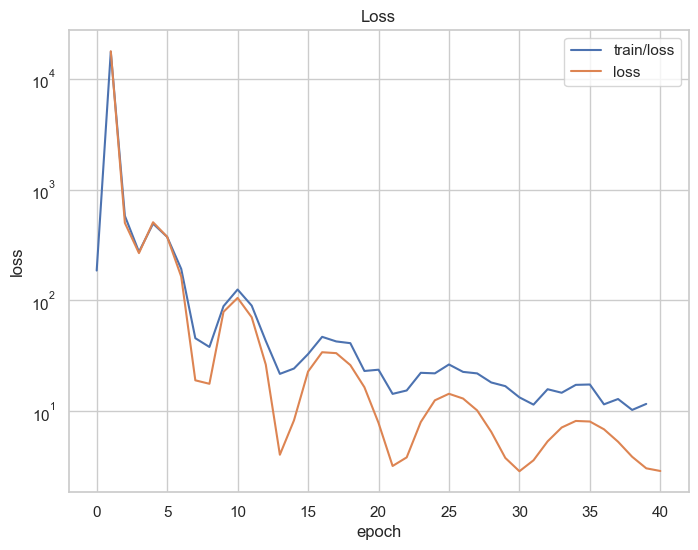

Epochs progress [Loss: 2.884e+00]: 100%|██████████| 40/40 [00:11<00:00,  3.39Epoch/s]


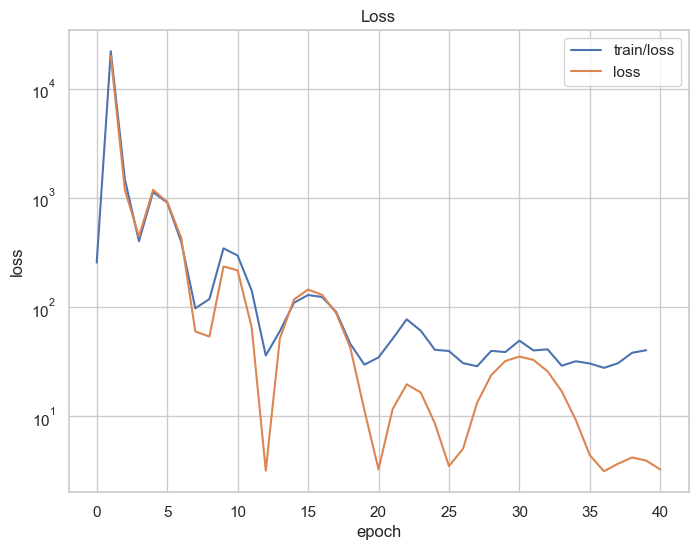

Epochs progress [Loss: 3.242e+00]: 100%|██████████| 40/40 [00:12<00:00,  3.33Epoch/s]


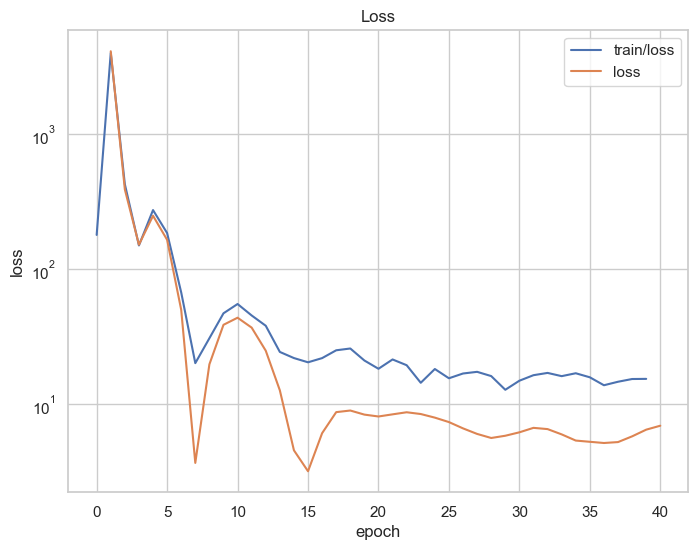

Epochs progress [Loss: 6.962e+00]: 100%|██████████| 40/40 [00:11<00:00,  3.35Epoch/s]


In [65]:
# train default regression model

from models.MLP import *

trainers = []
for dt in datas:
    model = MLP(MLPConfig.create(params, n_classes=dt.sample_batch()[1].shape[-1]))
    trainer = Trainer(TrainerConfig.create(params))
    trainers.append(trainer)
    trainer.fit(model, dt.loaders())


In [67]:
# Evaluate model
# print(cmodel)
# for p in cmodel.named_parameters():
#     print(p)

for trainer in trainers:
    print(eval_model(trainer))

0it [00:00, ?it/s]

(2.883885383605957, {'pred': [(array([7.3936787, 7.379393 , 7.40994  , 7.385864 , 7.414164 , 7.3799496,
       7.413601 , 7.4110093, 7.39189  , 7.3898134], dtype=float32),)], 'loss': [(array([2.8838854], dtype=float32),)]})


0it [00:00, ?it/s]

(3.2421340942382812, {'pred': [(array([19.900276, 19.869228, 19.892841, 19.869795, 19.922297, 19.892134,
       19.927397, 19.921852, 19.897444], dtype=float32),)], 'loss': [(array([3.242134], dtype=float32),)]})


0it [00:00, ?it/s]

(6.961985111236572, {'pred': [(array([[ 6.053952 , 16.912601 ],
       [ 6.0424814, 16.869673 ],
       [ 6.0122323, 16.79053  ],
       [ 6.0398107, 16.859894 ],
       [ 6.0408854, 16.863016 ],
       [ 6.0667863, 16.927082 ],
       [ 6.061601 , 16.919104 ],
       [ 6.0717444, 16.949251 ],
       [ 6.0551014, 16.893644 ]], dtype=float32),)], 'loss': [(array([6.961985], dtype=float32),)]})


In [ ]:
from collections import OrderedDict


cols = dt_route.data[0].columns


def shuffle_analysis(data, trainer):
    shuffled_mse = {}
    for col in cols:
        data.shuffle(col)
        val_loader = data.loaders()[1]
        shuffled_mse[col] = eval_model(trainer, loader=val_loader)[0]  # MSE
    ordered = OrderedDict(sorted(shuffled_mse.items(), key=lambda x: x[1]))
    print(ordered)

In [73]:
for d, t in zip(datas, trainers):
    shuffle_analysis(d, t)

OrderedDict({'partcipant': 2.883885383605957, 'year athlete was born ': 2.883885383605957, 'climbing experience': 2.883885383605957, 'climbing frequency per week': 2.883885383605957, '20mm crimp strength absolute (KG)': 2.883885383605957, 'power-slap test (distance in cm)': 2.883885383605957, 'pull-ups (reps)': 2.883885383605957, 'horizontl reach (cm)': 2.883885383605957, 'vertical reach (cm)': 2.883885383605957, 'vertical jump reach height (cm)': 2.883885383605957, 'intermittent crimp hang test (seconds)': 2.883885383605957, 'bodyweight (kg)': 2.883885383605957, 'board grade #': 2.883885383605957, '20mm crimp strength to bodyweight ratio': 2.883885383605957, 'power slap test (ratio of reach height to test distance)': 2.883885383605957, 'vertical jump height (cm)': 2.883885383605957, 'sex_m': 2.883885383605957, 'Gym_aspire whitby': 2.883885383605957, 'Gym_bolder climbing ': 2.883885383605957, 'Gym_boulder parcscarburough': 2.883885383605957, 'Gym_junction climbing london': 2.8838853836

In [74]:
from data.Climb import *

target = ("vertical jump reach height (cm)",)
dt_reach = ClimbData(ClimbConfig.create(params, target=target, omit=target))

target = ("20mm crimp strength to bodyweight ratio",)
dt_ratio = ClimbData(ClimbConfig.create(params, target=target, omit=target))
datas = [dt_reach, dt_ratio]

In [ ]:
# train default regression model

from models.MLP import *

trainers = []
for dt in datas:
    model = MLP(MLPConfig.create(params, n_classes=dt.sample_batch()[1].shape[-1]))
    trainer = Trainer(TrainerConfig.create(params))
    trainers.append(trainer)
    trainer.fit(model, dt.loaders())
